In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import romberg
from scipy.stats import norm
import paramonte as pm
sns.set()

In [2]:
df = pd.read_csv("https://www.cdslab.org/recipes/programming/regression-censored-mvn-data/data.csv", header=0)

In [3]:
X = np.double(df.iloc[:,0])
Y = np.double(df.iloc[:,1])
logX = np.log(X)
logY = np.log(Y)

<IPython.core.display.Javascript object>


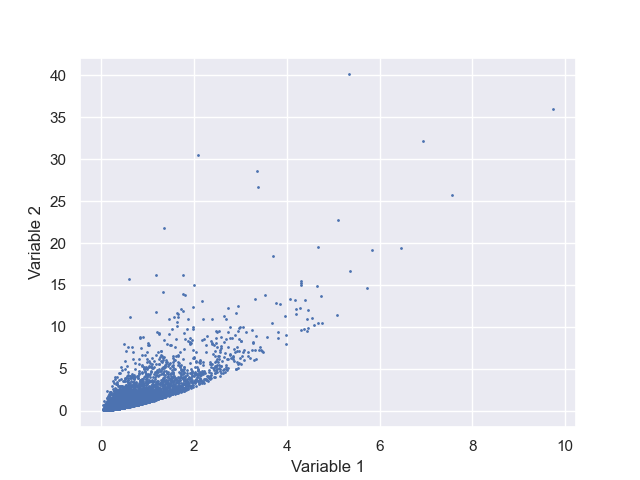

In [10]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlabel("Variable 1")
ax.set_ylabel("Variable 2")
plt.scatter(X,Y,s=1)
plt.show()

<IPython.core.display.Javascript object>


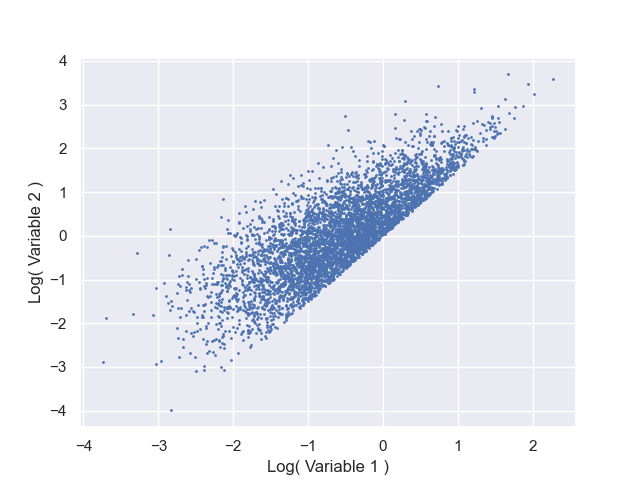

In [12]:
fig = plt.figure()
ax = fig.gca()
plt.scatter(logX, logY, s=1)
ax.set_xlabel("Log( Variable 1 )")
ax.set_ylabel("Log( Variable 2 )")
plt.show()

<IPython.core.display.Javascript object>


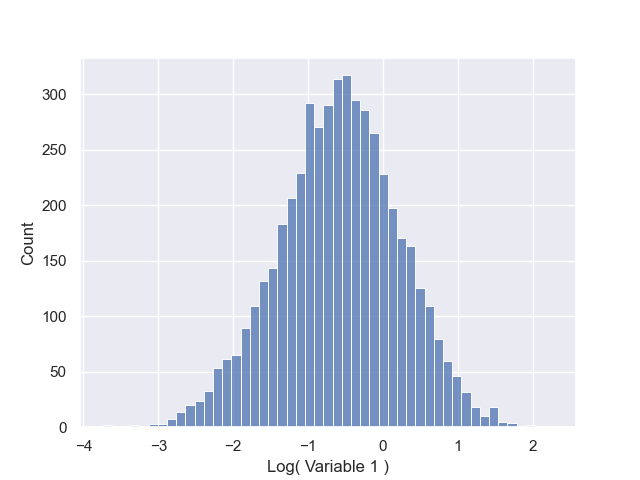

In [13]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlabel("Log( Variable 1 )")
ax.set_ylabel("Count")
sns.histplot(logX)
plt.show()

In [15]:
print("logX mean: " + str(round(logX.mean(),3)))
print("logX std: " + str(round(logX.std(),3)))

logX mean: -0.588
logX std: 0.809


<IPython.core.display.Javascript object>


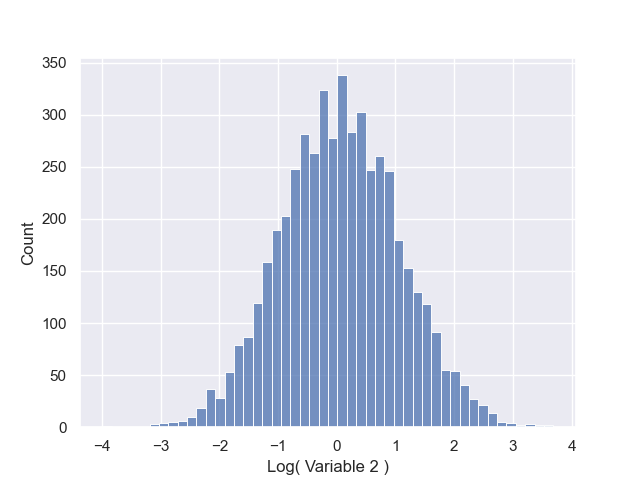

In [16]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlabel("Log( Variable 2 )")
ax.set_ylabel("Count")
sns.histplot(logY)
plt.show()

In [17]:
print("logY mean: " + str(round(logY.mean(),3)))
print("logY std: " + str(round(logY.std(),3)))

logY mean: 0.061
logY std: 1.009


In [134]:
class Normal():
    
    def __init__(self, logX, logY):
        if len(logX) != len(logY): return print("Error: dataset lengths not equivalent")

        self.data = np.transpose(np.double([logX,logY]))
        self.ndata = len(logX)
        self.NDIM = 2
        self.coef0 = self.NDIM * np.log( 1. / np.sqrt(2.*np.pi) )        

        self._rho = None
        self._stdX = None
        self._stdY = None
        self._covMat = None
        self._meanVec = None
        self._stdRatio = None
        self._stdXGivenY = None
        self._cutoffIntercept = None
        self._cutoffSlopeInverse = None
        self._lowerLimY = None # for romberg intergation
        self._upperLimY = None # for romberg intergation

    def integrateXGivenY(self,yval):
        avgXGivenY = self._meanVec[0] + self._stdRatio * self._rho * (yval - self._meanVec[1])
        threshX = (yval - self._cutoffIntercept) * self._cutoffSlopeInverse 
        return norm.pdf(x = yval, loc = self._meanVec[1], scale = self._stdY) \
             * norm.cdf(x = threshX, loc = avgXGivenY, scale = self._stdXGivenY)

    def getNormFac(self):
        return romberg( function = self.integrateXGivenY
                      , a = self._lowerLimY
                      , b = self._upperLimY
                      )

    def getLogLike(self, param):
        """
        Order of variables in param:
        param[0] = avg(x)
        param[1] = avg(y)
        param[2] = logStd(x)
        param[3] = logStd(y)
        param[4] = FirsherTrans(self._rho)
        param[5] = cutoffSlope
        param[6] = cutoffIntercept
        """
        self._rho = np.tanh(param[4])
        self._meanVec = np.double(param[0:2])
        self._covMat = np.zeros([self.NDIM,self.NDIM])
        self._stdX = np.exp(param[2])
        self._stdY = np.exp(param[3])
        self._covMat[0,0] = (self._stdX)**2
        self._covMat[1,1] = (self._stdY)**2
        self._covMat[1,0] = self._rho * self._stdX * self._stdY
        self._covMat[0,1] = self._covMat[1,0]
        self._stdXGivenY = np.sqrt( self._covMat[0,0] * (1-self._rho**2) )
        self._stdRatio = self._stdX / self._stdY
        self._cutoffSlopeInverse = 1 / param[5]
        self._cutoffIntercept = param[6]
        significance = 4 * self._stdY
        self._lowerLimY = self._meanVec[1] - significance
        self._upperLimY = self._meanVec[1] + significance

        if np.linalg.det(self._covMat) == 0: 
            import sys
            sys.exit("disaster happended.")
        
        invCovMat = np.linalg.inv(self._covMat) # This is the inverse of the covariance matrix of the MVN distribution.

        # The following is the log of the coefficient used in the definition of the MVN.

        coef = self.coef0 + np.log( np.sqrt(np.linalg.det(invCovMat)) )  

        # the logarithm of objective function: log(MVN)

        logLike = 0.
        for obs in self.data:
            if obs[1] < (param[5] * obs[0] + param[6]): 
                return -1.e100 # -np.inf
            else:
                normedPoint = self._meanVec - obs
                logLike += coef - 0.5 * ( np.dot(normedPoint, np.matmul(invCovMat,normedPoint)) )
        return logLike - np.log(self.getNormFac())*self.ndata

In [135]:
normal = Normal(logX,logY)

In [3]:
pmpd = pm.ParaDRAM()

In [17]:
pmpd = pm.ParaDRAM()
pmpd.spec.chainSize = 100000
pmpd.spec.variableNameList = [ "AverageLogX", "AverageLogY", "LogStandardDeviationX", "LogStandardDeviationY"
                             , "FirsherTrans(rho)", "cutoffSlope", "cutoffIntercept"]
pmpd.spec.startPointVec = [.45131034E-01,.41661606E-01,.19017040E-01,.20989582E-01,.72429954,1.4998417,-.10499574E-03]
pmpd.spec.targetAcceptanceRate = [0.1,0.2]
pmpd.spec.sampleSize = 2000

In [ ]:
pmpd.runSampler( ndim = 7
               , getLogFunc = normal.getLogLike
               )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.



In [5]:
pmpd.readSample("C:\\Users\\cmbac\\Python\\SampleIncompleteness\\ParaDRAM_run_20200930_195752_257")


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readSample()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the sample file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "C:\Users\cmbac\Python\SampleIncompleteness\ParaDRAM_run_20200930_195752_257*_sample.txt"


ParaDRAM - NOTE: processing sample file: C:\Users\cmbac\Python\SampleIncompleteness\ParaDRAM_run_20200930_195752_257_process_1_sample.txt
ParaDRAM - NOTE: reading the file contents... done in 0.006501 seconds.
ParaDRAM - NOTE: ndim = 7, count = 2000
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
Para

ParaDRAM - NOTE: making the grid plot... 


<IPython.core.display.Javascript object>


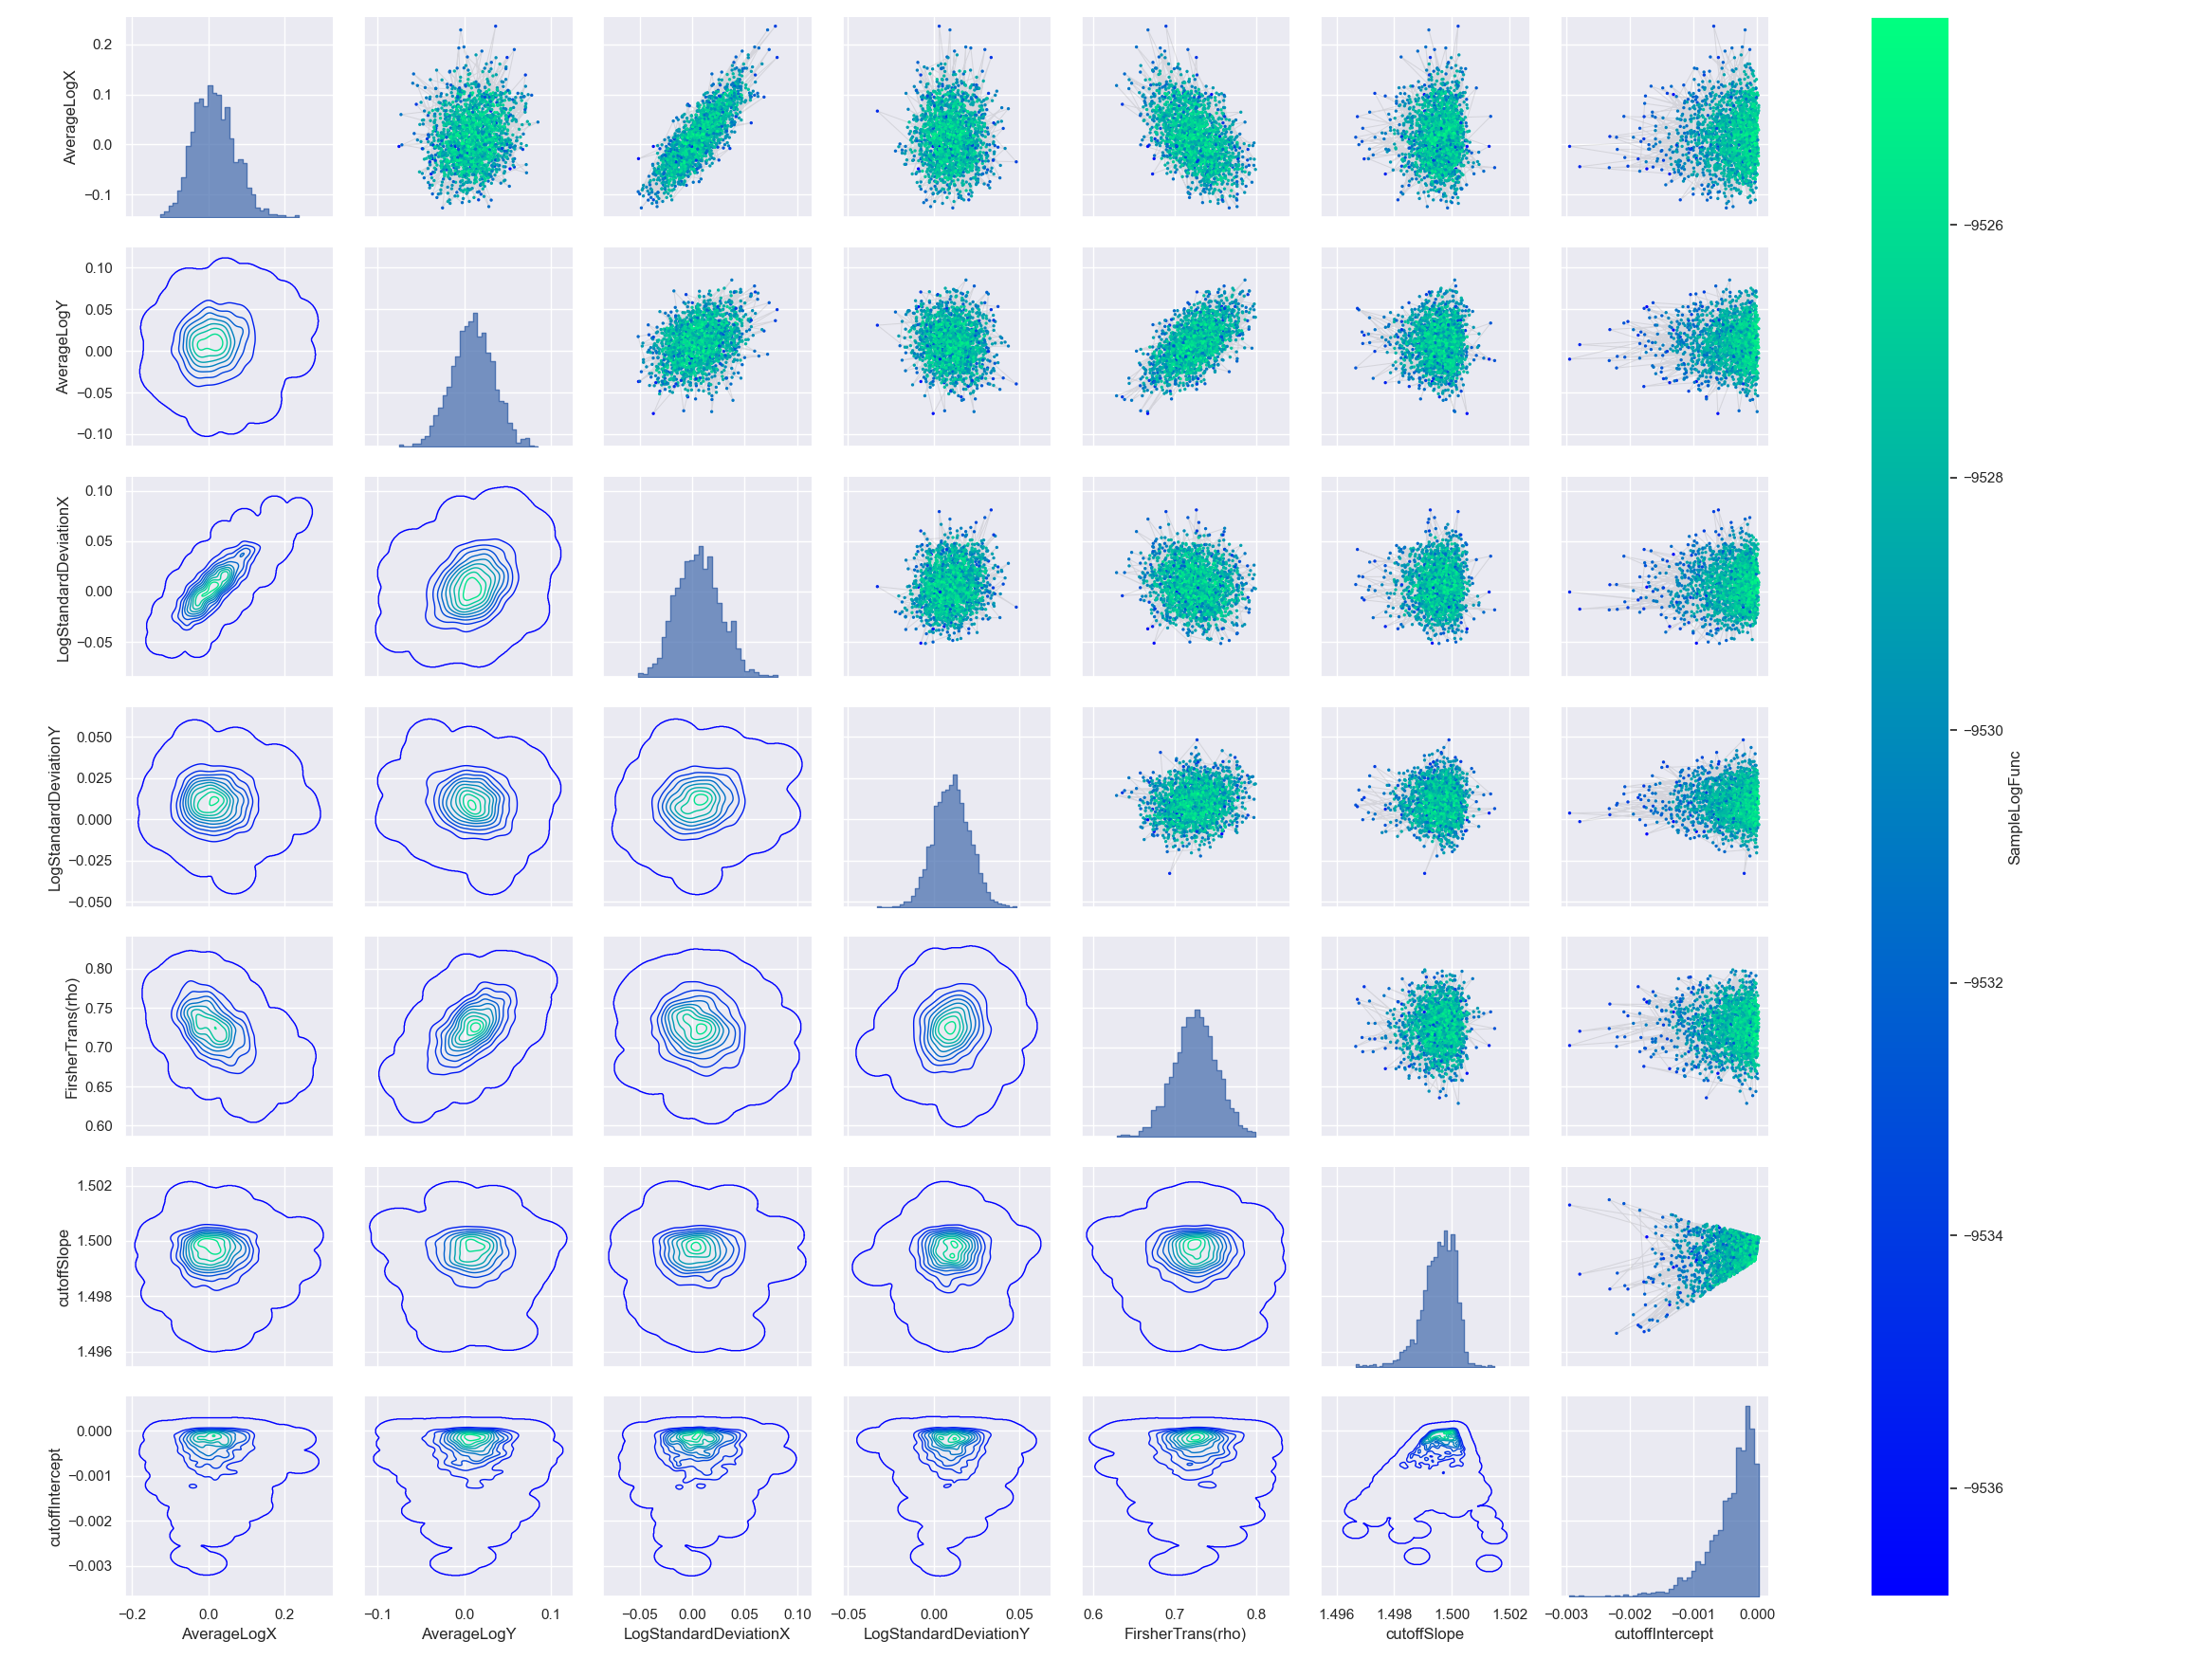

generating subplot #1: (0,0) out of 49... done in 0.025845 seconds.
generating subplot #2: (0,1) out of 49... done in 1.693299 seconds.
generating subplot #3: (0,2) out of 49... done in 1.64229 seconds.
generating subplot #4: (0,3) out of 49... done in 1.635789 seconds.
generating subplot #5: (0,4) out of 49... done in 1.623287 seconds.
generating subplot #6: (0,5) out of 49... done in 1.628288 seconds.
generating subplot #7: (0,6) out of 49... done in 1.616786 seconds.
generating subplot #8: (1,0) out of 49... done in 1.797598 seconds.
generating subplot #9: (1,1) out of 49... done in 0.025845 seconds.
generating subplot #10: (1,2) out of 49... done in 1.634289 seconds.
generating subplot #11: (1,3) out of 49... done in 1.640289 seconds.
generating subplot #12: (1,4) out of 49... done in 1.625787 seconds.
generating subplot #13: (1,5) out of 49... done in 1.630788 seconds.
generating subplot #14: (1,6) out of 49... done in 1.619787 seconds.
generating subplot #15: (2,0) out of 49... d

In [6]:
pmpd.sampleList[0].plot.grid(columns = [1,2,3,4,5,6,7])

In [12]:
pmpd.sampleList[0].df.describe()

,SampleLogFunc,AverageLogX,AverageLogY,LogStandardDeviationX,LogStandardDeviationY,FirsherTrans(rho),cutoffSlope,cutoffIntercept
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-9527.999653,0.014558,0.009583,0.005918,0.010334,0.724664,1.499541,-0.000419
std,1.969519,0.053009,0.023988,0.020642,0.010343,0.026281,0.000575,0.000377
min,-9536.858900,-0.127038,-0.075268,-0.051530,-0.032905,0.628507,1.496667,-0.002946
25%,-9529.135700,-0.023978,-0.006529,-0.008826,0.003227,0.707878,1.499215,-0.000594
50%,-9527.727100,0.011736,0.009755,0.005440,0.010363,0.725054,1.499608,-0.000316
75%,-9526.508950,0.049377,0.025801,0.019502,0.017354,0.742239,1.499968,-0.000145
max,-9524.356100,0.236357,0.085255,0.080856,0.048187,0.798619,1.501487,0.000028


In [22]:
print("Avg X = " + str(round(np.exp(pmpd.sampleList[0].df.describe()["AverageLogX"]["mean"]),2)))
print("Avg Y = " + str(round(np.exp(pmpd.sampleList[0].df.describe()["AverageLogY"]["mean"]),2)))
print("Std X = " + str(round(np.exp(pmpd.sampleList[0].df.describe()["LogStandardDeviationX"]["mean"]),2)))
print("Std Y = " + str(round(np.exp(pmpd.sampleList[0].df.describe()["LogStandardDeviationY"]["mean"]),2)))
print("rho = " + str(round(np.tanh(pmpd.sampleList[0].df.describe()["FirsherTrans(rho)"]["mean"]),2)))
print("Cutoff Slope = " + str(round(pmpd.sampleList[0].df.describe()["cutoffSlope"]["mean"],2)))
print("Cutoff Intercept = " + str(round(pmpd.sampleList[0].df.describe()["cutoffIntercept"]["mean"],2)))

Avg X = 1.01
Avg Y = 1.01
Std X = 1.01
Std Y = 1.01
rho = 0.62
Cutoff Slope = 1.5
Cutoff Intercept = -0.0
